### Instantaneous Source Separation (ISS) Algorithm
### Matthew Yeseta

### Separater multiple sources from a mixed signal where the mixing signal process is assumed to be instantaneous and have no time delay between the sources and the mixed signals.

Algorithm can be summarized in the following steps:
1. Center the data
2. Whiten the data
3. Initialize the weight matrix
4. Iteratively update the weight matrix using the fixed-point iteration scheme until convergence.
5. Reconstruct the independent sources



### Independent Component Analysis (ICA)

#### Step 1: Centering
Center the mixed signals by subtracting the mean to make the signal zero-mean.

\[ X = X - \text{mean}(X) \]

#### Step 2: Whitening
Whiten the centered signals using Principal Component Analysis (PCA) to make the components uncorrelated and their variances equal to one.

\[ X_{white} = V D^{-1/2} V^T X \]

where \(V\) is the matrix of eigenvectors and \(D\) is the diagonal matrix of eigenvalues of the covariance matrix of \(X\).

#### Step 3: Initialize Weight Matrix
Initialize the weight matrix \(W\) with small random values.

#### Step 4: Iterative Update
Update the weight matrix \(W\) iteratively using a fixed-point iteration scheme. For each weight vector \(w_i\):

1. **Compute the projection**:

\[ y_i = W^T X \]

2. **Non-linear function**: Apply a non-linear function \(g(y)\). Common choices are:
   - \( g(y) = \tanh(y) \)
   - \( g(y) = y \exp(-y^2/2) \)
   - \( g(y) = y^3 \)

3. **Update rule**: Update the weight vector \(w_i\) using:

\[ w_i \leftarrow \mathbb{E}[X g(w_i^T X)] - \mathbb{E}[g'(w_i^T X)] w_i \]

   where \( \mathbb{E} \) denotes the expectation, and \( g' \) is the derivative of \( g \).

4. **Orthogonalization**: Ensure the weight vectors remain orthogonal:

\[ w_i \leftarrow w_i - \sum_{j=1}^{i-1} (w_i^T w_j) w_j \]

5. **Normalization**: Normalize the weight vector:

\[ w_i \leftarrow \frac{w_i}{\|w_i\|} \]

Repeat this process until convergence.

#### Step 5: Reconstruct Sources
The separated sources can be reconstructed using the final weight matrix \(W\):

\[ S = W^T X \]

### Summary
The FastICA algorithm can be summarized in the following steps:
1. **Center the data**.
2. **Whiten the data**.
3. **Initialize the weight matrix**.
4. **Iteratively update the weight matrix** using the fixed-point iteration scheme until convergence.
5. **Reconstruct the independent sources**.

This approach assumes that the sources are statistically independent and non-Gaussian. ICA is powerful in applications like blind source separation, where the goal is to separate mixed signals without prior knowledge of the source signals or the mixing process.

In [14]:
import time
from datetime import timedelta as td
import os
import IPython
from scipy.io import wavfile
import scipy.signal
import numpy as np
import random 
import matplotlib.pyplot as plt
from matplotlib import colormaps
import librosa
import seaborn as sns

import numpy as np
import librosa as lb
import librosa 
import pandas as pd
import os
import copy
from sklearn.decomposition import PCA
import IPython
import IPython.display as ipd
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io
from heapq import heappush
import heapq
import collections
import pandas as pd
from IPython.display import Audio

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [15]:
import librosa as lb
import numpy as np
import matplotlib.pyplot as plt

dir_path = 'C:\\Users\\matth\\Documents\\master-degree\\data'
os.chdir(dir_path)
dir_path = os.getcwd()

data = []
src_rate = 0
for m in range(1,20):
    xica = 'x_ica_' + str(m+1) + '.wav'
    wave, src_rate = lb.load(os.path.join(dir_path, xica), sr = None) 
    data.append(np.array(wave))

    
signal_X = np.asarray(data)



In [16]:
ica_data = []
num_recordings = 20
for i in range(num_recordings):
    fs, sr = lb.load(os.path.join(dir_path, 'x_ica_' + str(i+1) + '.wav'), sr = None)
    ica_data.append(np.array(fs))
    
ica_data = np.array(ica_data)

ica_mean = np.mean(ica_data, axis=1).reshape(-1,1)
ica_centered = np.array(ica_data - ica_mean)
data_cov = np.dot(ica_centered, ica_centered.T)  * (1/(ica_centered.shape[1] - 1))
print(data_cov.shape)

(20, 20)


In [28]:
def pca_center_matrix(signal):
    _mean = np.mean(signal, axis=1)
    _centered = signal - _mean[:, np.newaxis]
    _cov = np.cov(_centered)
    return _cov, _centered

def pca_get_eigen(cv_signal):
    eigenvalues, eigenvectors = np.linalg.eig(cv_signal)
    return eigenvalues, eigenvectors

def pca_whiten(eigenvalues, eigenvectors, center):
    diagnal_eigen = np.diag(1 / np.sqrt(eigenvalues + 1e-8))
    whiten = np.dot(np.dot(eigenvectors, diagnal_eigen), eigenvectors.T) @ center
    return whiten  

def pca_computeN(eigenvalues, num_components):
    if num_components is None:
        num_components = np.sum(eigenvalues > 1e-7) 
        
    return num_components

def pca_dot(eigenvectors, N, whiten):
    projected_dot = np.dot(eigenvectors[:, :N].T, whiten)
    return projected_dot

def pca(signal, num_components=None):
    cv, center = pca_center_matrix(signal)
    eigenvalues, eigenvectors = pca_get_eigen(cv)
    whiten = pca_whiten(eigenvalues, eigenvectors, center)
    N = pca_computeN(eigenvalues, num_components)
    signal_audio = pca_dot(eigenvectors, N, whiten)
    
    return eigenvalues, signal_audio

def compute_normalized_signal(signal, number):
    rand = np.random.rand(signal.shape[0], 1)
    normalized = 0
    for _ in range(1500):
        dot_update = np.dot(signal, rand)
        normalized = dot_update / np.linalg.norm(dot_update)  
    return normalized

def build_vectors(signal, N):
    _mean = np.mean(signal, axis=1).reshape(-1,1)
    _expected = np.array(signal - _mean)
    signal_cov = np.dot(_expected, _expected.T)  * (1/(_expected.shape[1] - 1))
    
    values = []
    vectors = []
    for x in range(0, N):
        Y = np.random.rand(signal_cov.shape[0], 1)
        for z in range(0,1000):
            Y = np.dot(signal_cov, Y)
            Y = Y * (1/np.power(np.sum(np.power(Y,2)),0.5))
        _value = np.power(np.sum(np.power(np.dot(Y.T, signal_cov), 2)), 0.5)
        values.append(_value)
        vector = np.dot(signal_cov.T, Y) * (1/_value)
        signal_residual = signal_cov - (_value * np.dot(Y, vector.T))
        vectors.append(Y.reshape(-1,))
    vectors = np.array(vectors)
    return vectors.T, values, signal_residual

def build_power_eigenvectors(X, num_EigenVectors):
    vectors = []
    values = []
    for i in range(0,num_EigenVectors):
        Y = np.random.rand(X.shape[0], 1)
        for j in range(0,1000):
            Y = np.dot(X, Y)
            Y = Y * (1/np.power(np.sum(np.power(Y,2)),0.5))
        value = np.power(np.sum(np.power(np.dot(Y.T, X), 2)), 0.5)
        values.append(value)
        vector = np.dot(X.T, Y) * (1/value)
        residual_vector = value * np.dot(Y, vector.T)
        X = X - residual_vector
        vectors.append(Y.reshape(-1,))
    vectors = np.array(vectors)
    return vectors.T, values

def build_sound_reduction(X, number):
    e_vectors = []
    e_values = []
    for i in range(0, number):
        Y = np.random.rand(X.shape[0], 1)
        for j in range(0,1000):
            Y = np.dot(X, Y)
            Y = Y * (1/np.power(np.sum(np.power(Y,2)),0.5))
        value = np.power(np.sum(np.power(np.dot(Y.T, X), 2)), 0.5)
        e_values.append(value)
        vector = np.dot(X.T, Y) * (1/value)
        residual = value * np.dot(Y, vector.T)
        X = X - residual
        e_vectors.append(Y.reshape(-1,))
    e_vectors = np.array(e_vectors)
    return e_vectors.T, e_values

def compute_eigenvectors(C, num_components):
    eigenvalues, eigenvectors = np.linalg.eigh(C)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, idx[:num_components]]
    eigenvalues = eigenvalues[idx[:num_components]]
    return eigenvectors, eigenvalues

def ica(paramW, paramI, paramN, paramP, signal_audio, learning_rate, determinant):
    for i in range(0,1000):
        _prev = paramW
        _W = paramN*paramI - np.dot(np.tanh(paramP),np.transpose(np.power(paramP,3)))
        _delta = _W * _prev
        paramW = paramW + learning_rate * _delta
        _W_audio_dot = np.dot(paramW, signal_audio)
        _determinant = np.linalg.det(np.abs(_prev - paramW))
        determinant.append(_determinant)
        if np.allclose(paramW, _prev, rtol=1e-05, atol=1e-05):
            print("Converged at",i)    
            break
    return determinant

def soundICA(Z, training_rate, N):
    __delta_W = []
    __convergence = []
    __delta_W = np.identity(4)
    W = np.identity(4)
    Y = np.dot(W,Z)
    for i in range(0, 1000):
        __delta_W = np.dot((N*np.identity(4) - np.dot(np.tanh(Y), np.power(Y, 3).T)), W)
        W = W + training_rate * __delta_W
        Y = np.dot(W,Z)
        __convergence.append(np.sum(np.abs(__delta_W)))
    return W, __convergence

def g_func(Y):
    return np.tanh(Y)

def f_func(Y):
    return 1 - np.square(np.tanh(Y))

import scipy.sparse as sp

def setup_identify_matrix(N, reduced_data):
    identity_matrix = sp.eye(N, format='csr')
    paramW = np.random.randn(N, N) * 0.01
    identiy_signal_dot = np.dot(reduced_data, reduced_data.T)
    return paramW, identity_matrix, identiy_signal_dot



In [29]:
X_mean = np.mean(data, axis=1).reshape(-1,1)
X_Expected = np.array(data - X_mean)
data_cov = np.dot(X_Expected, X_Expected.T)  * (1/(X_Expected.shape[1] - 1))

learning_rate = 0.000001
eigenVectors, eigenValues = build_sound_reduction(data_cov, 20)
eigenVectors = eigenVectors[:,0:4] 
eigenVectors_scaled = np.multiply(eigenVectors, (1/np.sqrt(eigenValues[0:4])))
reduced_data = np.dot(eigenVectors_scaled.T, data)
W, convergence = soundICA(reduced_data, 0.000001, reduced_data.shape[1])
sound_reduced = np.dot(W, reduced_data)


In [30]:

from IPython.display import Audio
display(Audio(sound_reduced[0], rate = src_rate))
display(Audio(sound_reduced[1], rate = src_rate))
display(Audio(sound_reduced[2], rate = src_rate))
display(Audio(sound_reduced[3], rate = src_rate))

### PCA Pricipal Components

#### PCA Reduction:

pca_reduce, audio_signal = pca(data): 
  
This calls a PCA function on the dataset data. The function pca is expected to return two values:
pca_reduce: The eigenvalues resulting from the PCA. Eigenvalues represent the variance explained by each principal component. The components with the highest eigenvalues are the most significant.
audio_signal: This seems to be the projected data onto the principal components (the reduced-dimensional representation of the original data). However, without seeing the implementation of pca, this is an assumption based on typical PCA outputs.

#### Convergence plot
The plot analysis is useful for the "scree test", a visual method to determine the number of principal components to retain. The idea is to look for a point where the slope of the curve markedly changes (also known as the "elbow"), suggesting that subsequent components contribute significantly less to explaining the variance in the data.

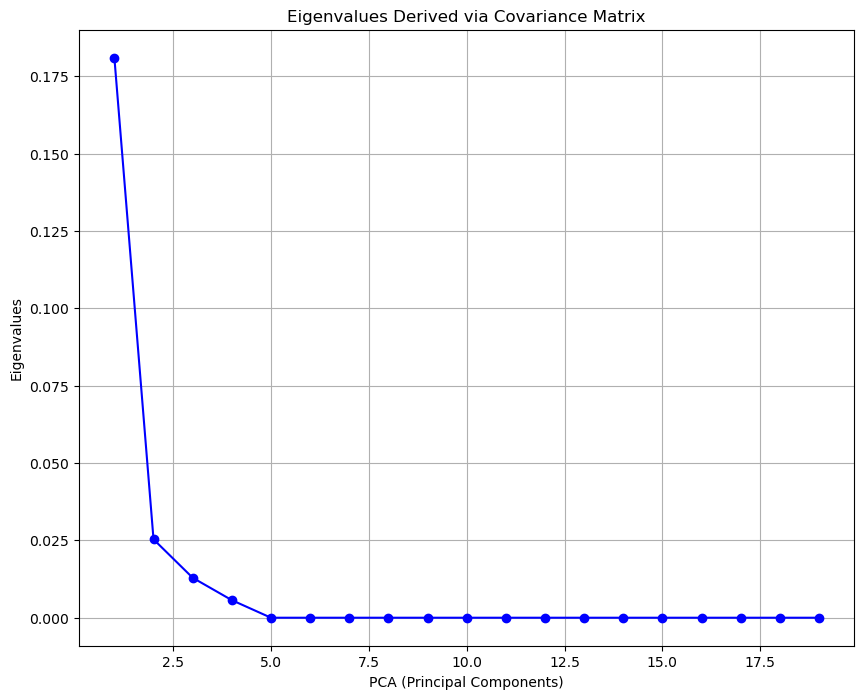

In [31]:
eigenvectors, eigenvalues = compute_eigenvectors(data_cov, 20) 

plt.figure(figsize=(10, 8))
plt.plot(np.arange(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='-', color='b')
plt.xlabel('PCA (Principal Components)')
plt.ylabel('Eigenvalues')
plt.title('Eigenvalues Derived via Covariance Matrix')
plt.grid()
plt.show()

### Independent Component Analysis (ICA)
Instantaneous source separion by applying the Independent Component Analysis (ICA) to audio signals and visualizing the convergence of the ICA algorithm through the error rates across iterations

#### Convergence to determine the number of components:

N = audio_signal.shape[1]: 
 
This determines the number of features (columns) in the audio_signal matrix. In the context of audio signal processing, this is our number of samples for the signal.

Setup for ICA:

paramW, paramI, identiy_signal_dot = setup_identify_matrix(N, audio_signal): 
 
This calls the function setup_identify_matrix, which is expected to perform preliminary setup for the ICA algorithm. The function takes the number of features N and the audio_signal as inputs and returns three items:
 
paramW: A weight matrix initialized for the ICA process.
paramI: Presumably an identity matrix or another parameter essential for the ICA computation.
 
identiy_signal_dot: 
 
The dot product involving an identity matrix and the audio_signal, possibly part of initializing or preprocessing the signal.

#### Perform ICA:

determinant = []:
 
Initializes an empty list to store determinants or another metric of error across iterations of the ICA algorithm.

determinant = ica(paramW, N, paramI, identiy_signal_dot, audio_signal, determinant): 
 
This runs the ICA algorithm by calling the ica function with the previously initialized parameters and the audio signal. The function is expected to update the determinant list with values representing the convergence or error rate at each iteration of the algorithm.


In [34]:
eigenvalues, reduced_data = pca(data_cov, 3)

N = reduced_data.shape[0]
learning_rate = 1e-6

paramW, paramI, identity_signal_dot = setup_identify_matrix(N, reduced_data)

determinant = []
determinant = ica(paramW, N, paramI, identity_signal_dot, reduced_data, learning_rate, determinant)


Converged at 408


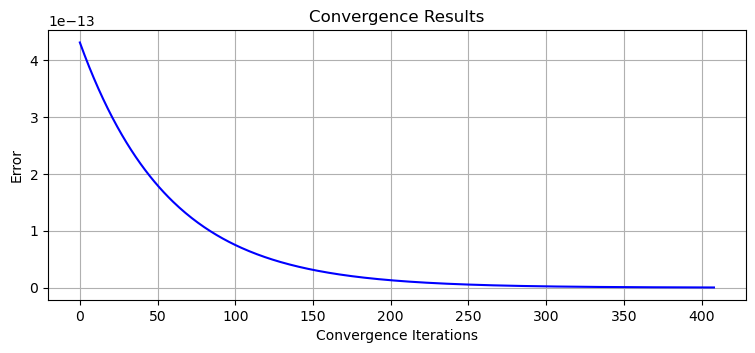

In [35]:
X_audio_signal = np.arange(0,len(determinant))

plt.figure(figsize=(9, 3.5))
sns.lineplot(x = X_audio_signal, y=determinant, color = "blue")
plt.xlabel("Convergence Iterations")
plt.ylabel("Error")
plt.title("Convergence Results") ;
plt.grid()
plt.show()